
<img align="left" style="max-width: 200px" src="https://github.com/HSG-AIML/IGARSS2023_EfficientDeepLearningEO/blob/main/01-data_fusion/banner_igarss2023.png?raw=1">
<img align="right" style="max-width: 200px" src="https://github.com/HSG-AIML/IGARSS2023_EfficientDeepLearningEO/blob/main/01-data_fusion/hsg_logo.png?raw=1">

# IGARSS Tutorial *Data-efficient Deep Learning for Earth Observation* 2023


## Lab - "Multi-Task Learning"

*Michael Mommert, Joelle Hanna, Linus Scheibenreif, Damian Borth*


## Content

1. [Introduction](#introduction)
2. [Tasks](#tasks)
3. [Performance Measure](#performance-measure)
4. [Dataset](#dataset)
5. [Model Creation](#model)
6. [Training and Validation](#train-val)
7. [Evaluation](#evaluation)
8. [Features Visualisation](#features_visualisation)
9. [Conclusion](#conclusion)

<a id='introduction'></a>
## 1. Introduction

In this tutorial, we will implement and train a **deep multitask model** using the *PyTorch* library. The network will be trained on a **remote sensing** dataset for different downstream tasks, such as classification, segmentation and regression.

<a id='Tasks'></a>
## 2. Tasks

During the tutorial, we'll explore a range of tasks, providing you with insights on how to handle each one independently and how to effectively combine them to potentially optimize their overall performance. The chosen tasks are: (1) single-label multi-class classification, (2) semantic segmentation,  and (3) regression.

Setup is the following: we will use one shared backbone (U-Net), and three separate task-specific heads.

<img align="center" style="max-width: 1000px" src="https://github.com/HSG-AIML/IGARSS2023_EfficientDeepLearningEO/blob/main/02-mtl/multitask-u-net-architecture.png?raw=1">

<a id='performance-measure'></a>
## 3. Performance Measure

Here is a list of the performance measures used to evaluate the different tasks:

* **Classification Task**:
  * We will use the accuracy metric


* **Segmentation Task**:

  * **IoU**: Let $A$ be the ground truth map and $B$ the predicted one. Intersection over union (IoU) is given as:
$$IoU(A,B) = \frac{A \cap B}{A \cup B} = \frac{\text{Area of Intersection}}{\text{Area of Union}}$$    

* **Regression Task**:
  * We will use the Mean Absolute Error.

<a id='dataset'></a>
## 4. Dataset Creation

#### Basic Imports

In [1]:
# we install a number of missing modules
!pip install pytorch_lightning torchmetrics albumentations rasterio

# system level modules for handling files and file structures
import os
import tarfile
import copy

# scipy ecosystem imports for numerics, data handling and plotting
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# pytorch and helper modules
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback
from torchmetrics import Accuracy, JaccardIndex, MeanAbsoluteError

# fast image augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# rasterio for reading in satellite image data
import rasterio as rio
from rasterio.enums import Resampling

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.4/722.4 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 79.2 MB/s eta 0:00:00


#### Download and extract data

We download the **ben-ge-800** dataset using the `gdown` command, if not yet present:

In [2]:
if not os.path.exists('ben-ge-800.tar.gz'):
    !gdown 10n7V2piIgcbWCsCBdezus_H0aGuPw1bq

Downloading...
From: https://drive.google.com/uc?id=10n7V2piIgcbWCsCBdezus_H0aGuPw1bq
To: /content/ben-ge-800.tar.gz
100% 183M/183M [00:02<00:00, 66.8MB/s]


Then we extract the `tutorial-data.tar.gz` archive. To this end, we use the [tarfile](https://docs.python.org/3.6/library/tarfile.html) module from the Python standard library.

In [3]:
tar_path = os.path.join('ben-ge-800.tar.gz')
data_base_path = os.path.abspath('.')

with tarfile.open(tar_path, mode='r') as tar:
    tar.extractall(path=data_base_path)

data_base_path = os.path.join(data_base_path, 'ben-ge-800')

#### Pytorch's dataset and dataloader

In this session, we use the same BENGE dataset class defined in the previous session (see _lab_df.ipynb_ for more information)

In [4]:
class BENGE(Dataset):
    """A dataset class implementing all ben-ge data modalities."""
    def __init__(self, data_dir=None,
                 s2_bands=["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B11", "B12"],
                 s1_bands=["VH", "VV"]):
        """Dataset class constructor

        keyword arguments:
        data_dir -- string containing the path to the base directory of ben-ge dataset, default: ben-ge-800 directory
        s2_bands -- list of Sentinel-2 bands to be extracted, default: all bands
        s1_bands -- list of Senintel-1 bands to be extracted, default: all bands

        returns:
        BENGE object
        """
        super(BENGE, self).__init__()

        # store some definitions
        if data_dir is None:
            self.data_dir = data_base_path
        else:
            self.data_dir = data_dir
        self.s2_bands = s2_bands
        self.s1_bands = s1_bands
        self.augmentation = A.Compose([ToTensorV2(),])

        # read in relevant data files and definitions
        self.name = self.data_dir.split("/")[-1]
        self.meta = pd.read_csv(f"{self.data_dir}/{self.name}_meta.csv")
        self.ewc_labels = pd.read_csv(f"{self.data_dir}/{self.name}_esaworldcover.csv")
        self.ewc_label_names = ["tree_cover", "shrubland", "grassland", "cropland", "built-up",
                                "bare/sparse_vegetation", "snow_and_ice","permanent_water_bodies",
                                "herbaceous_wetland", "mangroves","moss_and_lichen"]
        self.s2_resampling_factors = {"B01": 6, "B02": 1, "B03": 1, "B04": 1, "B05": 2, "B06": 2, "B07": 2, "B08": 1, "B09": 6, "B11": 2, "B12": 2, "B8A": 2}

    def __getitem__(self, idx):
        """Return sample `idx` as dictionary from the dataset."""
        sample_info = self.meta.iloc[idx]
        patch_id = sample_info.patch_id  # extract Sentinel-2 patch id
        patch_id_s1 = sample_info.patch_id_s1  # extract Sentinel-1 patch id

        s2 = self.load_s2(patch_id).astype(float)  # load Sentinel-2 data
        s2 = np.moveaxis(s2, 0, -1)
        if self.s1_bands:
            s1 = self.load_s1(patch_id_s1).astype(float)  # load Sentinel-1 data
            s1 = (np.clip(s1, a_min=-25, a_max=0) + 25) / 25
        else:
            s1 = None

        # extract top land-use/land-cover label
        label = np.argmax(self.ewc_labels[self.ewc_labels.patch_id == patch_id][self.ewc_label_names])

        # land-use/land-cover map data
        ewc_mask = self.load_ewc(patch_id).astype(float)
        ewc_mask[ewc_mask == 100] = 110
        ewc_mask[ewc_mask == 95] = 100
        ewc_mask = ewc_mask / 10 - 1 # transform to scale [0, 11]
        ewc_mask = np.moveaxis(ewc_mask, 0, -1)

        augmented = self.augmentation(image=s2, mask=ewc_mask)  # generate augmented data

        # reassign and normalize augmented Sentinel-2 data
        s2 = torch.clip(augmented["image"].float() / 10000, 0, 1)

        # reassign augmented land-use/land-cover data
        ewc_mask = augmented["mask"]

        season = sample_info["season_s2"] # seasonal data
        climatezone = {0: 0, 7: 1, 8: 2, 9: 3, 14: 4, 15: 5, 16: 6, 18: 7,
                       25: 8, 26: 9, 27: 10, 29: 11}[sample_info["climatezone"]]  # climatezone data

        # create sample dictionary containing all the data
        sample = {
            "s2": s2,
            "lulc_mask": ewc_mask,
            "patch_id": patch_id,
            "lon": sample_info.lon.item(),
            "lat": sample_info.lat.item(),
            "lulc_top": torch.from_numpy(np.array([label.copy()], dtype=float)),
            "season": season,
            "climatezone": climatezone
            }

        if s1 is not None:  # add Sentinel-1 data, if generated
            sample["s1"] = torch.tensor(s1).float()

        return sample

    def __len__(self):
        """Return length of this dataset."""
        return self.meta.shape[0]

    def load_s2(self, patch_id):
        """Helper function to load Sentinel-2 data for a given `patch_id`."""
        img = []

        for band in self.s2_bands:
            upscale_factor = self.s2_resampling_factors.get(band)
            # read corresponding data file and upsample based on resampling factor
            with rio.open(f"{self.data_dir}/sentinel-2/{patch_id}/{patch_id}_{band}.tif") as d:
                data = d.read(
                out_shape=(
                    d.count,
                    int(d.height * upscale_factor),
                    int(d.width * upscale_factor)
                ),
                resampling=Resampling.bilinear
            )
            img.append(data)

        img = np.concatenate(img)
        return img

    def load_s1(self, s1_patch_id):
        """Helper function to load Sentinel-1 data for a given `patch_id`."""
        img = []

        for band in self.s1_bands:
            # read corresponding data file
            with rio.open(f"{self.data_dir}/sentinel-1/{s1_patch_id}/{s1_patch_id}_{band}.tif") as d:
                data = d.read()
                img.append(data)

        img = np.concatenate(img)
        return img

    def load_ewc(self, patch_id):
        """Helper function to load ESAWorldCover data for a given `patch_id`."""
        with rio.open(f"{self.data_dir}/esaworldcover/{patch_id}_esaworldcover.tif") as d:
            data = d.read()

        return data

    def visualize_observation(self, idx):
        """Visualize data sample `idx`."""

        # define ESA WorldCover colormap
        COLOR_CATEGORIES = [
            (0, 100, 0),
            (255, 187, 34),
            (255, 255, 76),
            (240, 150, 255),
            (250, 0, 0),
            (180, 180, 180),
            (240, 240, 240),
            (0, 100, 200),
            (0, 150, 160),
            (0, 207, 117),
            (250, 230, 160)]
        cmap_all = mpl.colors.ListedColormap(np.array(COLOR_CATEGORIES)/255.)

        # read sample
        sample = self.__getitem__(idx)
        image = sample.get("s2").squeeze()
        mask = sample.get("lulc_mask")

        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        img_rgb = image[[3, 2, 1], :, :]
        img_rgb = np.transpose(img_rgb, (1, 2, 0))
        scaled_img_rgb = (img_rgb - np.min(img_rgb.numpy(), axis=(0,1)))/(np.max(img_rgb.numpy(), axis=(0,1))-np.min(img_rgb.numpy(), axis=(0,1)))

        axs[0].imshow(np.clip(1.5*scaled_img_rgb + 0.1, 0, 1))
        axs[0].set_title("Sentinel-2 RGB")
        axs[0].axis('off')

        mask = mask.squeeze()

        axs[1].imshow(mask, cmap=cmap_all, vmin=0, vmax=11, interpolation=None)
        axs[1].set_title(" Climate Zone: {} \n Season: {} \n Segmentation Mask".format(sample.get("climatezone"), sample.get("season")))
        axs[1].axis('off')

        plt.tight_layout()
        plt.show()
        return

    def visualise_predictions(self, idx, predictions):

        # define ESA WorldCover colormap
        COLOR_CATEGORIES = [
            (0, 100, 0),
            (255, 187, 34),
            (255, 255, 76),
            (240, 150, 255),
            (250, 0, 0),
            (180, 180, 180),
            (240, 240, 240),
            (0, 100, 200),
            (0, 150, 160),
            (0, 207, 117),
            (250, 230, 160)]

        season, climate_zone, land_cover = predictions

        cmap_all = mpl.colors.ListedColormap(np.array(COLOR_CATEGORIES)/255.)

        # read sample
        sample = self.__getitem__(idx)
        image = sample.get("s2").squeeze()
        mask = sample.get("lulc_mask")

        fig, axs = plt.subplots(1, 3, figsize=(17, 6))

        img_rgb = image[[3, 2, 1], :, :]
        img_rgb = np.transpose(img_rgb, (1, 2, 0))
        scaled_img_rgb = (img_rgb - np.min(img_rgb.numpy(), axis=(0,1)))/(np.max(img_rgb.numpy(), axis=(0,1))-np.min(img_rgb.numpy(), axis=(0,1)))

        axs[0].imshow(np.clip(1.5*scaled_img_rgb + 0.1, 0, 1))
        axs[0].set_title("Sentinel-2 RGB")
        axs[0].axis('off')

        axs[1].imshow(land_cover, cmap=cmap_all, vmin=0, vmax=11)
        axs[1].set_title(" Predictions \n Climate Zone: {} \n Season: {} \n Segmentation Mask".format(climate_zone, season))
        axs[1].axis('off')

        mask = mask.squeeze()

        axs[2].imshow(mask, cmap=cmap_all, vmin=0, vmax=11, interpolation=None)
        axs[2].set_title(" Climate Zone: {} \n Season: {} \n Segmentation Mask".format(sample.get("climatezone"), sample.get("season")))
        axs[2].axis('off')

        plt.tight_layout()
        plt.show()
        return

In [5]:
class BENGEDataModule(pl.LightningDataModule):
    """Pytorch Lightning data module class for ben-ge."""
    def __init__(self):
        """BENGEDataModule constructor."""
        super(BENGEDataModule).__init__()

    def prepare_data(self):
        """Method to prepare data."""
        pass

    def setup(self, data_dir, train_batch_size, eval_batch_size):
        """Method to setup dataset and corresponding splits."""
        dataset = BENGE(data_dir)
        self.trainset, self.valset = torch.utils.data.random_split(dataset, [int(len(dataset)*0.75), int(len(dataset)*0.25)])
        self.valset, self.testset = torch.utils.data.random_split(self.valset, [int(len(dataset)*0.125), int(len(dataset)*0.125)])

        self.train_bs = train_batch_size
        self.eval_bs = eval_batch_size

    def train_dataloader(self):
        """Return training dataset loader."""
        return torch.utils.data.DataLoader(
            self.trainset, batch_size=self.train_bs, num_workers=4, pin_memory=True
        )

    def val_dataloader(self):
        """Return validation dataset loader."""
        return torch.utils.data.DataLoader(
            self.valset, batch_size=self.eval_bs, num_workers=4, pin_memory=True
        )
    def test_dataloader(self):
        """Return test dataset loader."""
        return torch.utils.data.DataLoader(
            self.testset, batch_size=self.eval_bs, num_workers=4, pin_memory=True
        )

In [6]:
# we set the random seed value...
seed = 42
pl.seed_everything(seed)

train_batch_size = 32
eval_batch_size = 32

# ... and initialize the data module
data_module = BENGEDataModule()
data_module.setup("./ben-ge-800", train_batch_size, eval_batch_size)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


#### Display some samples

We can visualise some observations using the method *visualize_observation()*. Data visualization is the simplest part, but also the most important, to understand the task, and improve the performance of the model. It is important to check a couple of sampledataset, making sure that the groundtruh you're working with is consistent.

In [7]:
train_idx = data_module.trainset.indices[0]
val_idx = data_module.valset.indices[0]

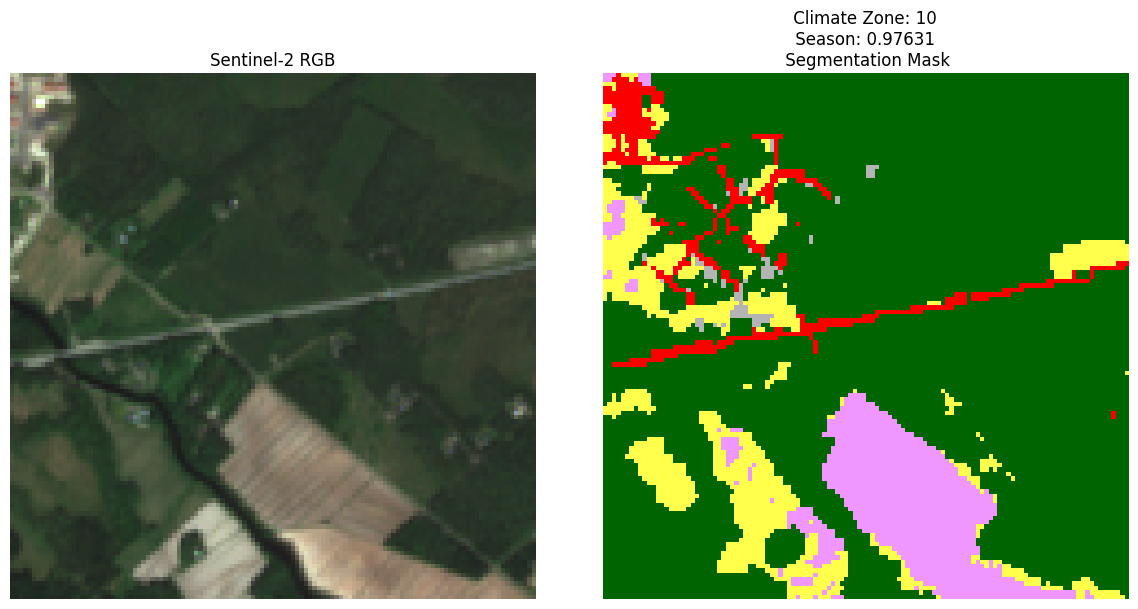

In [8]:
data_module.trainset.dataset.visualize_observation(train_idx)

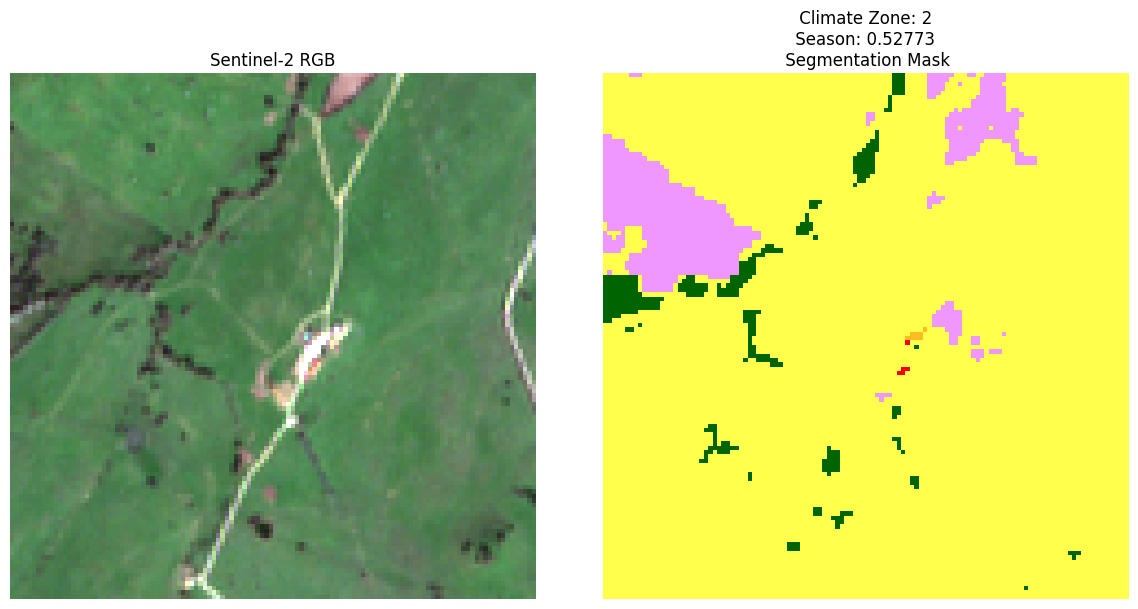

In [9]:
data_module.valset.dataset.dataset.visualize_observation(val_idx)

<a id='model'></a>
## 5. Model Creation

In this tutorial, we will use a U-Net ([Ronneberger et al. (2015)](https://arxiv.org/abs/1505.04597) as the shared backbone. As a Fully Convolutional Neural Network, it is predestined to work with image-like data and makes no assumption on the size of the input data (height and width). The architecture of U-Net is composed of two "paths":
- The first one is the contracting path, also called the *encoder*. It is used to capture the context of an image. It is in fact a group of convolution layers and max pooling layers allowing to create a feature map of an image and to reduce its size in order to reduce the number of network parameters.
- The second path is the symmetric expanding, also called *decoder*.

Although conceived as a segmentation model, we will use it across a wide range of downstream tasks, such as segmentation, classification and regression. As a side note: the U-Net could be easily replaced with most other Deep Learning models (depending on the downstream task).


For each downstream task, we will append to the decoder a separate head that is related to the corresponding task.


We build a simple U-Net implementation (following [this implementation](https://github.com/milesial/Pytorch-UNet)):

We will start by defining the different building blocks of this network, namely the downsampling blocks, the upsampling blocks, the double convolution blocks and the output block.

In [10]:
# Create the convolution block
class DoubleConv(nn.Module):
    """
    The DoubleConv object is composed of two successive blocks of convolutional layers, batch normalization and ReLU.
    """
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels

        # Create a sequential module.
        # nn.Sequential is a module inside which you can put other modules that will be applied one after the other.
        self.double_conv = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),

            # First batchnormalization
            nn.BatchNorm2d(mid_channels),

            # First ReLU activation function
            nn.ReLU(inplace=True),

            # Second convolutional layer
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),

            # Second batchnormalization
            nn.BatchNorm2d(out_channels),

            # Second ReLU activation function
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


# Create the downsampling block
class Down(nn.Module):
    """
    The Down object is composed of a maxpooling layer followed by the DoubleConv block defined above.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # Create a sequential module.
        self.maxpool_conv = nn.Sequential(
            # 2D max pooling layer with a kernel size of 2 (meaning spatial dimension will be divided by two)
            nn.MaxPool2d(2),

            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


# Create the upsampling block
class Up(nn.Module):
    """
    The Up object is composed of an upsampling layer (bilinear interpolation) followed by the DoubleConv block defined above.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # upsampling layer with a scale factor of 2 (meaning spatial dimension will be multiplied by two)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


In [11]:
class UNetBackbone(nn.Module):
    """U-Net implementation based on the previously defined building blocks."""
    def __init__(self, n_channels):
        super(UNetBackbone, self).__init__()
        self.n_channels = n_channels

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor)
        self.up2 = Up(512, 256 // factor)
        self.up3 = Up(256, 128 // factor)
        self.up4 = Up(128, 64)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        return x

Please note that the output of the U-Net will be a feature map of the same size (width x height) as the input image and with 64 output channels (this is a design choice; the number of output channels will be reduced in the head, depending on the downstream task).

We define the different task heads. Those heads are appended to the output of the decoder.

In [12]:
class MulticlassClassificationHead(nn.Module):
    def __init__(self, in_channels, out_channels, num_class):
        super(MulticlassClassificationHead, self).__init__()
        self.out_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

        self.fc = nn.Sequential(nn.Dropout(p=0.5), nn.Linear(120 * 120, num_class))

    def forward(self, x):
        x1 = self.out_conv(x)
        x2 = x1.view(-1, 120 * 120)
        x_out = self.fc(x2)
        return x_out

class MulticlassSegmentationHead(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MulticlassSegmentationHead, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class RegressionHead(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(RegressionHead, self).__init__()
        self.out_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.fc = nn.Sequential(nn.Dropout(p=0.1), nn.Linear(120 * 120, 1))

    def forward(self, x):
        x1 = self.out_conv(x)
        x2 = x1.view(-1, 120 * 120)
        x_out = self.fc(x2)
        return x_out

And now plugging everything together. First for single-tasks:

In [13]:
class SingleTaskSegUNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(SingleTaskSegUNet, self).__init__()

        self.backbone = UNetBackbone(n_channels)
        self.out = MulticlassSegmentationHead(64, n_classes)

    def forward(self, x):
        x = self.backbone(x)

        x_out = self.out(x)

        return x_out

In [14]:
class SingleTaskClsUNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(SingleTaskClsUNet, self).__init__()

        self.backbone = UNetBackbone(n_channels)

        self.out = MulticlassClassificationHead(64, 1, n_classes)

    def forward(self, x):
        x = self.backbone(x)

        x_out = self.out(x)

        return x_out

In [15]:
class SingleTaskRegUNet(nn.Module):
    def __init__(self, n_channels):
        super(SingleTaskRegUNet, self).__init__()

        self.backbone = UNetBackbone(n_channels)

        self.out = RegressionHead(64, 1)

    def forward(self, x):
        x = self.backbone(x)

        x_out = self.out(x)

        return x_out.squeeze()

And then for the multitask model

In [16]:
class MultiTaskUNet(nn.Module):
    def __init__(self, n_channels, n_classes_climatezone, n_classes_landcover):
        super(MultiTaskUNet, self).__init__()

        self.backbone = UNetBackbone(n_channels)

        self.out_seg = MulticlassSegmentationHead(64, n_classes_landcover)
        self.out_cls = MulticlassClassificationHead(64, 1, n_classes_climatezone)
        self.out_reg = RegressionHead(64, 1)

    def forward(self, x):
        x = self.backbone(x)

        x_out_seg = self.out_seg(x)
        x_out_cls = self.out_cls(x)
        x_out_reg = self.out_reg(x)

        return x_out_seg, x_out_cls, x_out_reg

This concludes the models implementation.

<a id='train-val'></a>
## 6. Training and Validation

First of all, let's verify if a GPU is available on our compute machine. If not, the CPU will be used instead.

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Device used: {}'.format(device))

Device used: cuda:0


In [18]:
class MetricTracker(Callback):
    """This class tracks and enables access to metrics generated during the training process."""
    def __init__(self):
        self.collection = []

    def on_validation_epoch_end(self, trainer, module):
        elogs = copy.deepcopy(trainer.callback_metrics)
        self.collection.append(elogs)

### Single Tasks:

In [21]:
class SingleTaskUNetTrainer(pl.LightningModule):
    def __init__(
        self,
        model,
        criterion,
        optimizer,
        scheduler,
        task='segmentation',
        lr_scheduler=False,
    ):
        super().__init__()
        assert task in ["classification", "segmentation", "regression"]
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.lr_scheduler = lr_scheduler
        self.task = task

        # Train and Validation Metrics:
        if self.task == "classification":
            self.train_metric = Accuracy(task="multiclass", num_classes=12)
            self.val_metric = Accuracy(task="multiclass", num_classes=12)
        elif self.task == "segmentation":
            self.train_metric = JaccardIndex(task="multiclass", num_classes=11)
            self.val_metric = JaccardIndex(task="multiclass", num_classes=11)
        elif self.task == "regression":
            self.train_metric = MeanAbsoluteError()
            self.val_metric = MeanAbsoluteError()

    def forward(self, img):
        return self.model(img)

    def configure_optimizers(self):
        if self.lr_scheduler:
            lr_scheduler_config = {
                "scheduler": self.scheduler,
                "interval": "epoch",
                "frequency": 1,
                "monitor": "val_loss",
                "strict": True,
                "name": None,
            }
            return {"optimizer": self.optimizer, "lr_scheduler": lr_scheduler_config}
        else:
            return self.optimizer

    def loss(self, pred, target):
        return self.criterion(pred, target)

    def get_target(self, batch):
        if self.task == "classification":
            y = batch["climatezone"].squeeze().long()
        elif self.task == "segmentation":
            y = batch["lulc_mask"].squeeze().long()
        elif self.task == "regression":
            y = batch["season"].float()

        return y

    def training_step(self, train_batch, batch_idx):
        y = self.get_target(train_batch)
        data = train_batch["s2"].float()

        output = self.forward(data)

        train_metric = self.train_metric(output, y)
        train_loss = self.loss(output, y)

        stats = {
            "train_loss": train_loss.item(),
            "train_metric": train_metric.item(),
        }

        self.log_dict(stats, batch_size=data.shape[0], on_step=True, on_epoch=True, prog_bar=True)

        return train_loss

    def validation_step(self, val_batch, batch_idx):
        y = self.get_target(val_batch)
        data = val_batch["s2"].float()

        output = self.forward(data)

        val_metric = self.val_metric(output, y)
        val_loss = self.loss(output, y)

        stats = {
            "val_loss": val_loss.item(),
            "val_metric": val_metric.item(),
        }
        self.log_dict(stats, batch_size=data.shape[0], on_step=True, on_epoch=True, prog_bar=True)
        return val_loss

Our model is now ready to be trained. The following cell defines the missing components like the Loss function, the optimizer and learning rate scheduler and instantiates the trainer.

In [34]:
model_st_seg = SingleTaskSegUNet(n_channels=12, n_classes=11) # we instantiate the model

criterion = torch.nn.CrossEntropyLoss()

learning_rate = 0.00001  # we set the learning rate
optimizer = optim.Adam(model_st_seg.parameters(), lr=learning_rate) # we use Adam as our optimizer

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300) # we use a Cosine annealing learning rate schedulder

model_trainer = SingleTaskUNetTrainer(model_st_seg, criterion, optimizer, scheduler) # we instantiate the trainer

metrics_st_seg = MetricTracker() # we instantiate the metrics tracker

# ... and finally, we instantiate the trainer
trainer = pl.Trainer(
    accelerator='cuda' if 'cuda' in str(device) else 'cpu',
    devices=1,
    max_epochs=5,
    log_every_n_steps=1,
    accumulate_grad_batches=1,
    callbacks=([metrics_st_seg]),
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [35]:
trainer.fit(
    model_trainer, data_module.train_dataloader(), data_module.val_dataloader()
)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type                   | Params
--------------------------------------------------------
0 | model        | SingleTaskSegUNet      | 17.3 M
1 | criterion    | CrossEntropyLoss       | 0     
2 | train_metric | MulticlassJaccardIndex | 0     
3 | val_metric   | MulticlassJaccardIndex | 0     
--------------------------------------------------------
17.3 M    Trainable params
0         Non-trainable params
17.3 M    Total params
69.093    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


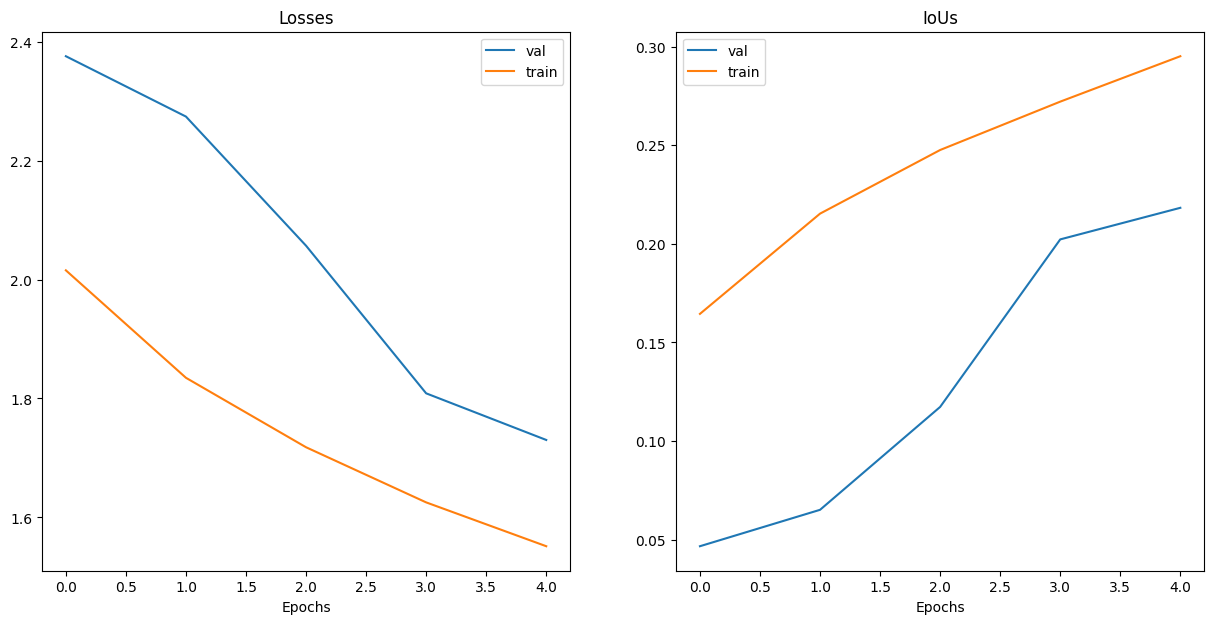

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
val_loss = [el['val_loss_epoch'].cpu() for el in metrics_st_seg.collection[1:]]
train_loss = [el['train_loss'].cpu() for el in metrics_st_seg.collection[1:]]

val_iou = [el['val_metric_epoch'].cpu() for el in metrics_st_seg.collection[1:]]
train_iou = [el['train_metric'].cpu() for el in metrics_st_seg.collection[1:]]

axes[0].plot(val_loss, label='val')
axes[0].plot(train_loss, label='train')
axes[0].set_xlabel('Epochs')
axes[0].set_title('Losses')
axes[0].legend()

axes[1].plot(val_iou, label='val')
axes[1].plot(train_iou, label='train')
axes[1].set_xlabel('Epochs')
axes[1].set_title('IoUs')
axes[1].legend()

In [38]:
model_st_cls = SingleTaskClsUNet(n_channels=12, n_classes=12) # we instantiate the model

criterion = torch.nn.CrossEntropyLoss()

learning_rate = 0.00001  # we set the learning rate
optimizer = optim.Adam(model_st_cls.parameters(), lr=learning_rate) # we use Adam as our optimizer

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300) # we use a Cosine annealing learning rate schedulder

model_trainer = SingleTaskUNetTrainer(model_st_cls, criterion, optimizer, scheduler, task='classification') # we instantiate the trainer

metrics_st_cls = MetricTracker() # we instantiate the metrics tracker

# ... and finally, we instantiate the trainer
trainer = pl.Trainer(
    accelerator='cuda' if 'cuda' in str(device) else 'cpu',
    devices=1,
    max_epochs=5,
    log_every_n_steps=1,
    accumulate_grad_batches=1,
    callbacks=([metrics_st_cls]),
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [39]:
trainer.fit(
    model_trainer, data_module.train_dataloader(), data_module.val_dataloader()
)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | model        | SingleTaskClsUNet  | 17.4 M
1 | criterion    | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 | val_metric   | MulticlassAccuracy | 0     
----------------------------------------------------
17.4 M    Trainable params
0         Non-trainable params
17.4 M    Total params
69.782    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


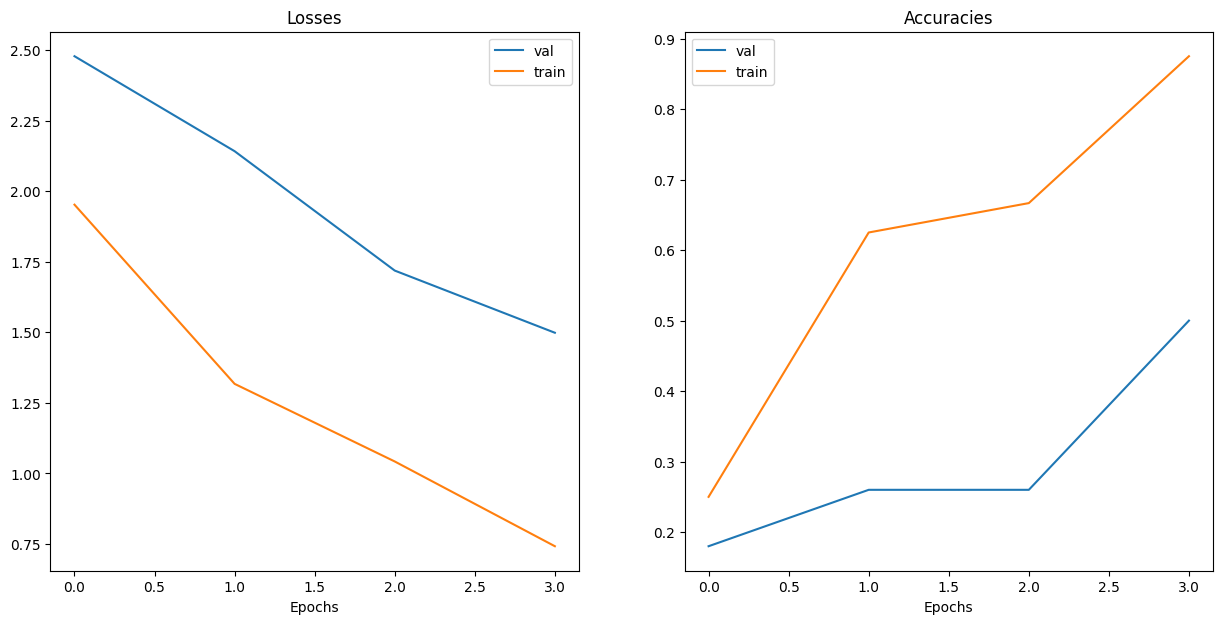

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
val_loss = [el['val_loss_epoch'].cpu() for el in metrics_st_cls.collection[1:-1]]
train_loss = [el['train_loss'].cpu() for el in metrics_st_cls.collection[1:-1]]

val_acc = [el['val_metric_epoch'].cpu() for el in metrics_st_cls.collection[1:-1]]
train_acc = [el['train_metric'].cpu() for el in metrics_st_cls.collection[1:-1]]

axes[0].plot(val_loss, label='val')
axes[0].plot(train_loss, label='train')
axes[0].set_xlabel('Epochs')
axes[0].set_title('Losses')
axes[0].legend()

axes[1].plot(val_acc, label='val')
axes[1].plot(train_acc, label='train')
axes[1].set_xlabel('Epochs')
axes[1].set_title('Accuracies')
axes[1].legend()

In [47]:
model_st_reg = SingleTaskRegUNet(n_channels=12) # we instantiate the model

criterion = torch.nn.MSELoss()

learning_rate = 0.00001  # we set the learning rate
optimizer = optim.Adam(model_st_reg.parameters(), lr=learning_rate) # we use Adam as our optimizer

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300) # we use a Cosine annealing learning rate schedulder

model_trainer = SingleTaskUNetTrainer(model_st_reg, criterion, optimizer, scheduler, task='regression') # we instantiate the trainer

metrics_st_reg = MetricTracker() # we instantiate the metrics tracker

# ... and finally, we instantiate the trainer
trainer = pl.Trainer(
    accelerator='cuda' if 'cuda' in str(device) else 'cpu',
    devices=1,
    max_epochs=5,
    log_every_n_steps=1,
    accumulate_grad_batches=1,
    callbacks=([metrics_st_reg]),
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [48]:
trainer.fit(
    model_trainer, data_module.train_dataloader(), data_module.val_dataloader()
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params
---------------------------------------------------
0 | model        | SingleTaskRegUNet | 17.3 M
1 | criterion    | MSELoss           | 0     
2 | train_metric | MeanAbsoluteError | 0     
3 | val_metric   | MeanAbsoluteError | 0     
---------------------------------------------------
17.3 M    Trainable params
0         Non-trainable params
17

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


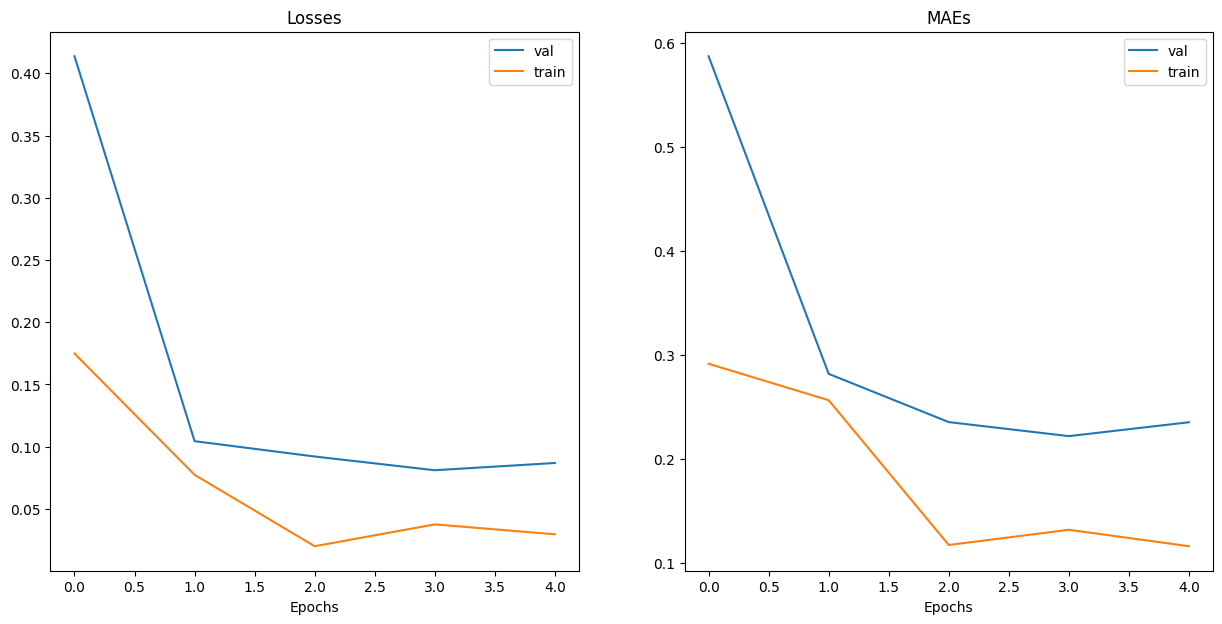

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
val_loss = [el['val_loss_epoch'].cpu() for el in metrics_st_reg.collection[1:]]
train_loss = [el['train_loss'].cpu() for el in metrics_st_reg.collection[1:]]

val_acc = [el['val_metric_epoch'].cpu() for el in metrics_st_reg.collection[1:]]
train_acc = [el['train_metric'].cpu() for el in metrics_st_reg.collection[1:]]

axes[0].plot(val_loss, label='val')
axes[0].plot(train_loss, label='train')
axes[0].set_xlabel('Epochs')
axes[0].set_title('Losses')
axes[0].legend()

axes[1].plot(val_acc, label='val')
axes[1].plot(train_acc, label='train')
axes[1].set_xlabel('Epochs')
axes[1].set_title('MAEs')
axes[1].legend()

### Multi Tasks:

In [55]:
class MultitaskUNetTrainer(pl.LightningModule):
    def __init__(
        self,
        model,
        seg_criterion,
        cls_criterion,
        reg_criterion,
        optimizer,
        scheduler,
        loss_weights=[1, 1, 1],
        lr_scheduler=False,
    ):
        super().__init__()
        self.model = model
        self.seg_criterion = seg_criterion
        self.cls_criterion = cls_criterion
        self.reg_criterion = reg_criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.lr_scheduler = lr_scheduler
        self.loss_weights = loss_weights

        # Training Metrics
        self.train_jaccard = JaccardIndex(task="multiclass", num_classes=11)
        self.train_accuracy = Accuracy(task="multiclass", num_classes=12)
        self.train_mae = MeanAbsoluteError()
        # Validation Metrics
        self.val_jaccard = JaccardIndex(task="multiclass", num_classes=11)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=12)
        self.val_mae = MeanAbsoluteError()

    def forward(self, img):
        return self.model(img)

    def configure_optimizers(self):
        if self.lr_scheduler:
            lr_scheduler_config = {
                "scheduler": self.scheduler,
                "interval": "epoch",
                "frequency": 1,
                "monitor": "val_loss",
                "strict": True,
                "name": None,
            }
            return {"optimizer": self.optimizer, "lr_scheduler": lr_scheduler_config}
        else:
            return self.optimizer

    def segmentation_loss(self, pred, true):
        return self.seg_criterion(pred, true)

    def classification_loss(self, pred, true):
        return self.cls_criterion(pred, true)

    def regression_loss(self, pred, true):
        return self.reg_criterion(pred, true)

    def weight_losses(self, losses):
        return self.loss_weights[0] * losses[0] + self.loss_weights[1] * losses[1]  + self.loss_weights[2] * losses[2]

    def training_step(self, train_batch, batch_idx):
        climate_zone = train_batch["climatezone"].long()
        season = train_batch["season"].float()
        mask = train_batch["lulc_mask"].squeeze().long()

        data = train_batch["s2"].float()

        output_seg, output_cls, output_reg = self.forward(data)

        train_iou = self.train_jaccard(output_seg, mask)
        train_acc = self.train_accuracy(output_cls, climate_zone)
        train_mae = self.train_mae(output_reg.squeeze(), season)

        loss_seg = self.segmentation_loss(output_seg, mask.squeeze())
        loss_cls = self.classification_loss(output_cls, climate_zone.squeeze())
        loss_reg = self.regression_loss(output_reg.squeeze(), season)

        train_loss = self.weight_losses([loss_seg, loss_cls, loss_reg])

        stats = {
            "train_loss": train_loss,
            "train_cls_loss": loss_cls,
            "train_seg_loss": loss_seg,
            "train_reg_loss": loss_reg,
            "train_accuracy": train_acc,
            "train_iou": train_iou,
            "train_mae": train_mae,
        }

        self.log_dict(stats, batch_size=data.shape[0], on_step=False, on_epoch=True)

        return train_loss


    def validation_step(self, val_batch, batch_idx):
        climate_zone = val_batch["climatezone"].long()
        season = val_batch["season"].float()
        mask = val_batch["lulc_mask"].squeeze().long()

        data = val_batch["s2"].float()

        output_seg, output_cls, output_reg = self.forward(data)

        loss_seg = self.segmentation_loss(output_seg, mask.squeeze())
        loss_cls = self.classification_loss(output_cls, climate_zone.squeeze())
        loss_reg = self.regression_loss(output_reg.squeeze(), season)

        val_loss = loss_cls + loss_seg + loss_reg

        val_iou = self.val_jaccard(output_seg, mask)
        val_acc = self.val_accuracy(output_cls, climate_zone)
        val_mae = self.val_mae(output_reg.squeeze(), season)

        stats = {
            "val_loss": val_loss,
            "val_accuracy": val_acc,
            "val_mae": val_mae,
            "val_iou": val_iou,
            "val_cls_loss": loss_cls,
            "val_seg_loss": loss_seg,
            "val_reg_loss": loss_reg,
        }

        self.log_dict(stats, batch_size=data.shape[0], on_step=False, on_epoch=True)


In [56]:
model_mt = MultiTaskUNet(n_channels=12, n_classes_climatezone=12, n_classes_landcover=11)

criterion_cls = torch.nn.CrossEntropyLoss()
criterion_seg = torch.nn.CrossEntropyLoss()
criterion_reg = torch.nn.MSELoss()


optimizer = optim.Adam(model_mt.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300)

model_trainer = MultitaskUNetTrainer(model_mt, criterion_seg, criterion_cls, criterion_reg, optimizer, scheduler, loss_weights=[1, 1, 1])

metrics_mt = MetricTracker()

trainer = pl.Trainer(
    accelerator='cuda' if 'cuda' in str(device) else 'cpu',
    devices=1,
    max_epochs=5,
    log_every_n_steps=1,
    accumulate_grad_batches=1,
    callbacks=([metrics_mt]),
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [57]:
trainer.fit(
    model_trainer, data_module.train_dataloader(), data_module.val_dataloader()
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type                   | Params
----------------------------------------------------------
0 | model          | MultiTaskUNet          | 17.5 M
1 | seg_criterion  | CrossEntropyLoss       | 0     
2 | cls_criterion  | CrossEntropyLoss       | 0     
3 | reg_criterion  | MSELoss                | 0     
4 | train_jaccard  | MulticlassJaccardIndex | 0     
5 | train_accurac

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


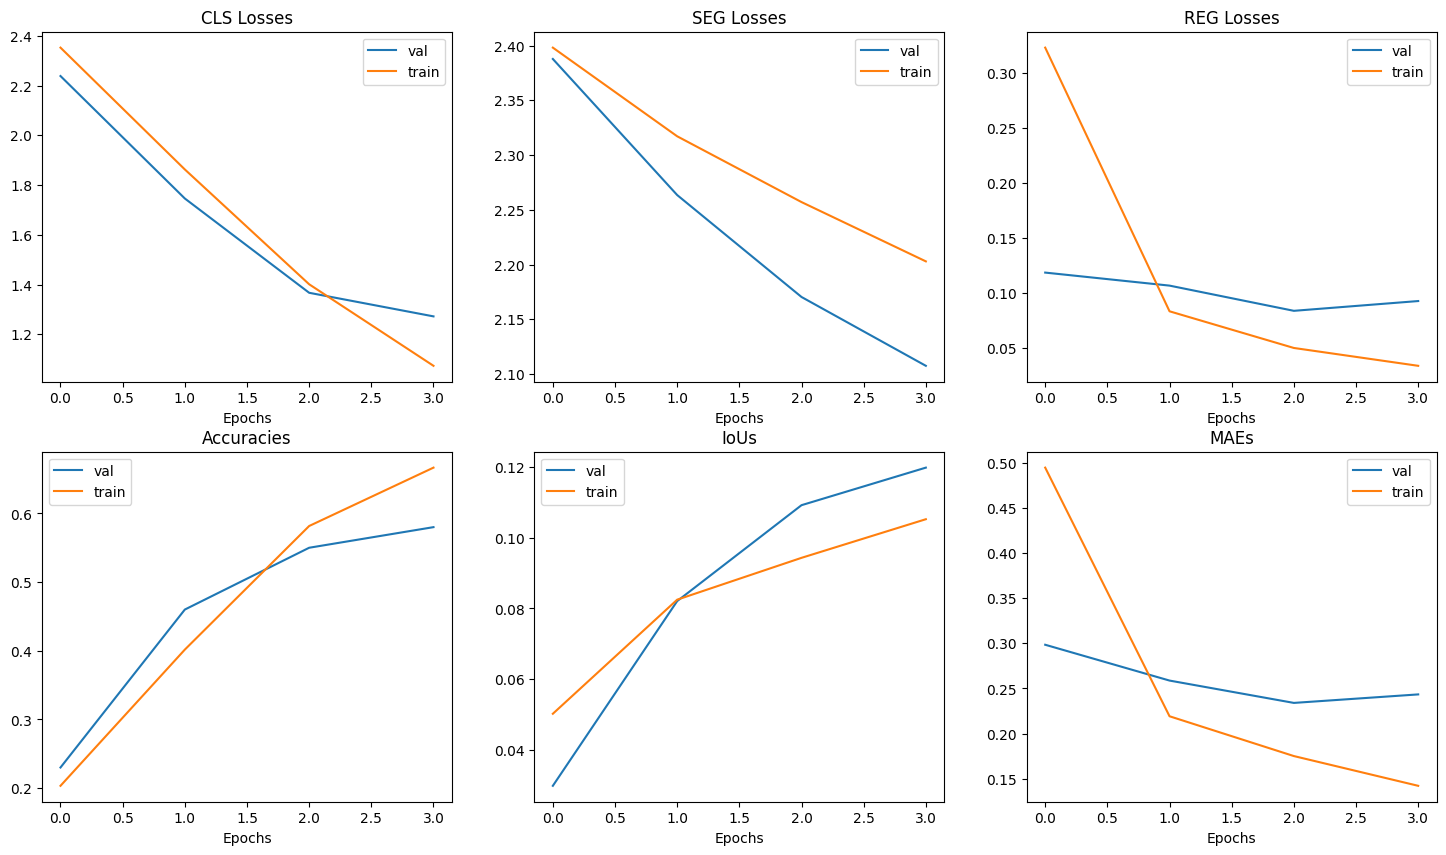

In [58]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
val_cls_loss = [el['val_cls_loss'].cpu() for el in metrics_mt.collection[2:]]
train_cls_loss = [el['train_cls_loss'].cpu() for el in metrics_mt.collection[2:]]

val_seg_loss = [el['val_seg_loss'].cpu() for el in metrics_mt.collection[2:]]
train_seg_loss = [el['train_seg_loss'].cpu() for el in metrics_mt.collection[2:]]

val_reg_loss = [el['val_reg_loss'].cpu() for el in metrics_mt.collection[2:]]
train_reg_loss = [el['train_reg_loss'].cpu() for el in metrics_mt.collection[2:]]

val_iou = [el['val_iou'].cpu() for el in metrics_mt.collection[2:]]
train_iou = [el['train_iou'].cpu() for el in metrics_mt.collection[2:]]

val_acc = [el['val_accuracy'].cpu() for el in metrics_mt.collection[2:]]
train_acc = [el['train_accuracy'].cpu() for el in metrics_mt.collection[2:]]

val_mae = [el['val_mae'].cpu() for el in metrics_mt.collection[2:]]
train_mae = [el['train_mae'].cpu() for el in metrics_mt.collection[2:]]

axes[0, 0].plot(val_cls_loss, label='val')
axes[0, 0].plot(train_cls_loss, label='train')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_title('CLS Losses')
axes[0, 0].legend()

axes[0, 1].plot(val_seg_loss, label='val')
axes[0, 1].plot(train_seg_loss, label='train')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_title('SEG Losses')
axes[0, 1].legend()

axes[0, 2].plot(val_reg_loss, label='val')
axes[0, 2].plot(train_reg_loss, label='train')
axes[0, 2].set_xlabel('Epochs')
axes[0, 2].set_title('REG Losses')
axes[0, 2].legend()

axes[1, 0].plot(val_acc, label='val')
axes[1, 0].plot(train_acc, label='train')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_title('Accuracies')
axes[1, 0].legend()

axes[1, 1].plot(val_iou, label='val')
axes[1, 1].plot(train_iou, label='train')
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_title('IoUs')
axes[1, 1].legend()

axes[1, 2].plot(val_mae, label='val')
axes[1, 2].plot(train_mae, label='train')
axes[1, 2].set_xlabel('Epochs')
axes[1, 2].set_title('MAEs')
axes[1, 2].legend()

These plots show that the results obtained with the multitask model are similar, if not slightly better, than those obtained with the single-task ones. However, the main advantage is undoubtedly the model's efficiency, thanks to the reduction in trainable parameters:

Let's start by displaying the number of trainable parameters of the multitask model `model_mt`:

In [59]:
num_params_mt = sum(p.numel() for p in model_mt.parameters() if p.requires_grad)

print(f'Number of trainable parameters in the multitask model: {num_params_mt / 1000000} M')

Number of trainable parameters in the multitask model: 17.46057 M


And the sum of trainable parameters in all single tasks models `model_st_seg`, `model_st_reg`, `model_st_cls`:

In [60]:
num_params_st = (
    sum(p.numel() for p in model_st_seg.parameters() if p.requires_grad)
    + sum(p.numel() for p in model_st_reg.parameters() if p.requires_grad)
    + sum(p.numel() for p in model_st_cls.parameters() if p.requires_grad)
)

print(f'Number of trainable parameters in the all single task models: {num_params_st / 1000000} M')

Number of trainable parameters in the all single task models: 52.005594 M


<a id='evaluation'></a>
## 7. Evaluation

In [65]:
# model_mt
test_idx = data_module.testset.indices[0]

In [66]:
X = data_module.valset.dataset.dataset.__getitem__(test_idx)['s2'].to(device)

model_mt.to(device)
model_mt.eval()
with torch.no_grad():
    output_seg, output_cls, output_reg = model_mt(X.unsqueeze(0))

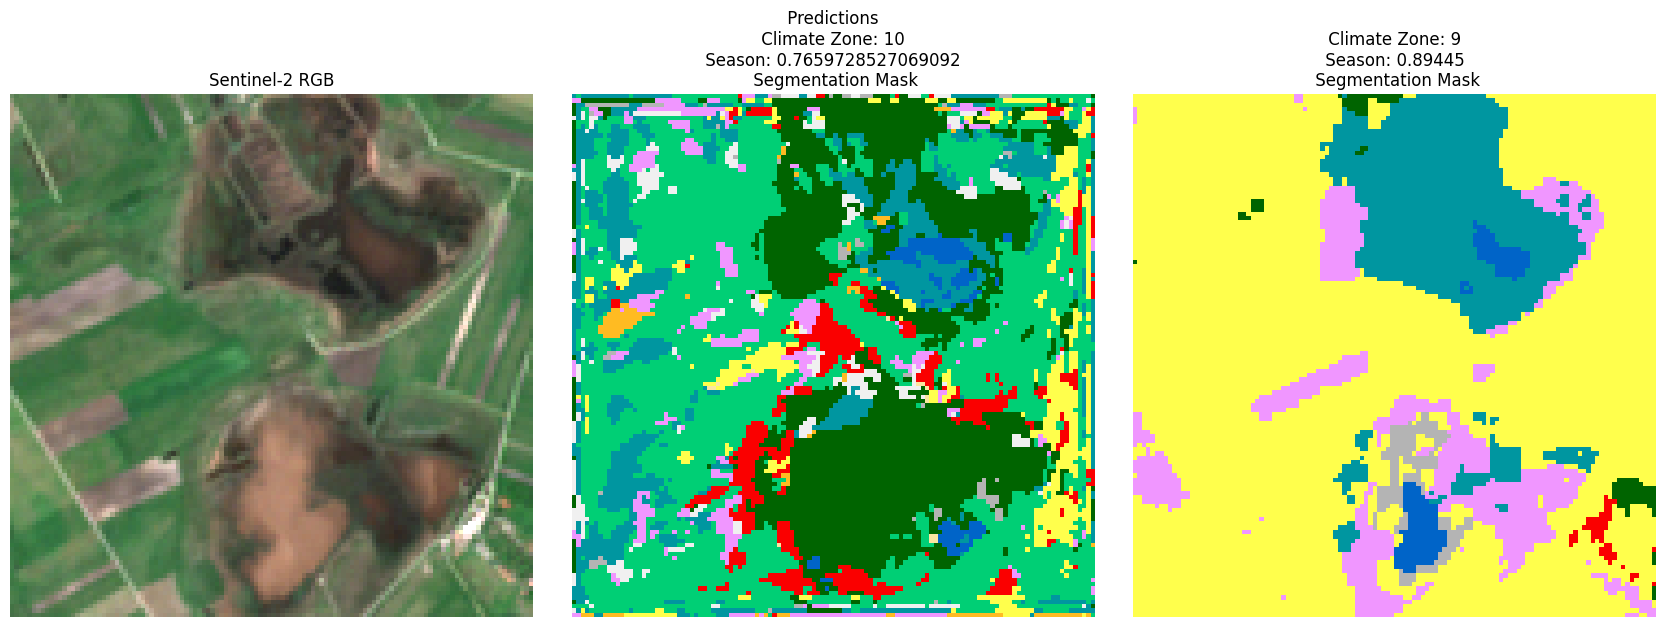

In [67]:
data_module.valset.dataset.dataset.visualise_predictions(test_idx, [output_reg.item(), torch.argmax(output_cls).item(), torch.argmax(output_seg.squeeze(), 0).cpu()])

Since there is not enough time during the tutorial to train properly a model, we will use a pre-trained model (trained on 100 epochs, ~1hour) to qualitatively assess the results.

In [68]:
!gdown 1_i39mIiEg8JyBo1baLLq53UJJu23_4A4

Downloading...
From: https://drive.google.com/uc?id=17XIHDjj9amEchb_vdwYS8-MSmpQHv4FC
To: /content/multitask-model.ckpt
100% 210M/210M [00:04<00:00, 50.0MB/s]


In [70]:
model_mt_tl = MultiTaskUNet(n_channels=12, n_classes_climatezone=12, n_classes_landcover=11)

path = '/content/multitask-model-checkpoint.ckpt'

model_weights = torch.load(path,  map_location='cpu')["state_dict"]

new_dict = model_weights.copy()

for key, value in model_weights.items():
    new_key = key.replace('model.', '')
    new_dict[new_key] = new_dict.pop(key)

model_mt_tl.load_state_dict(new_dict)

<All keys matched successfully>

In [72]:
X = data_module.valset.dataset.dataset.__getitem__(test_idx)['s2'].to(device)

model_mt_tl.to(device)
model_mt_tl.eval()
output_seg, output_cls, output_reg = model_mt_tl(X.unsqueeze(0))

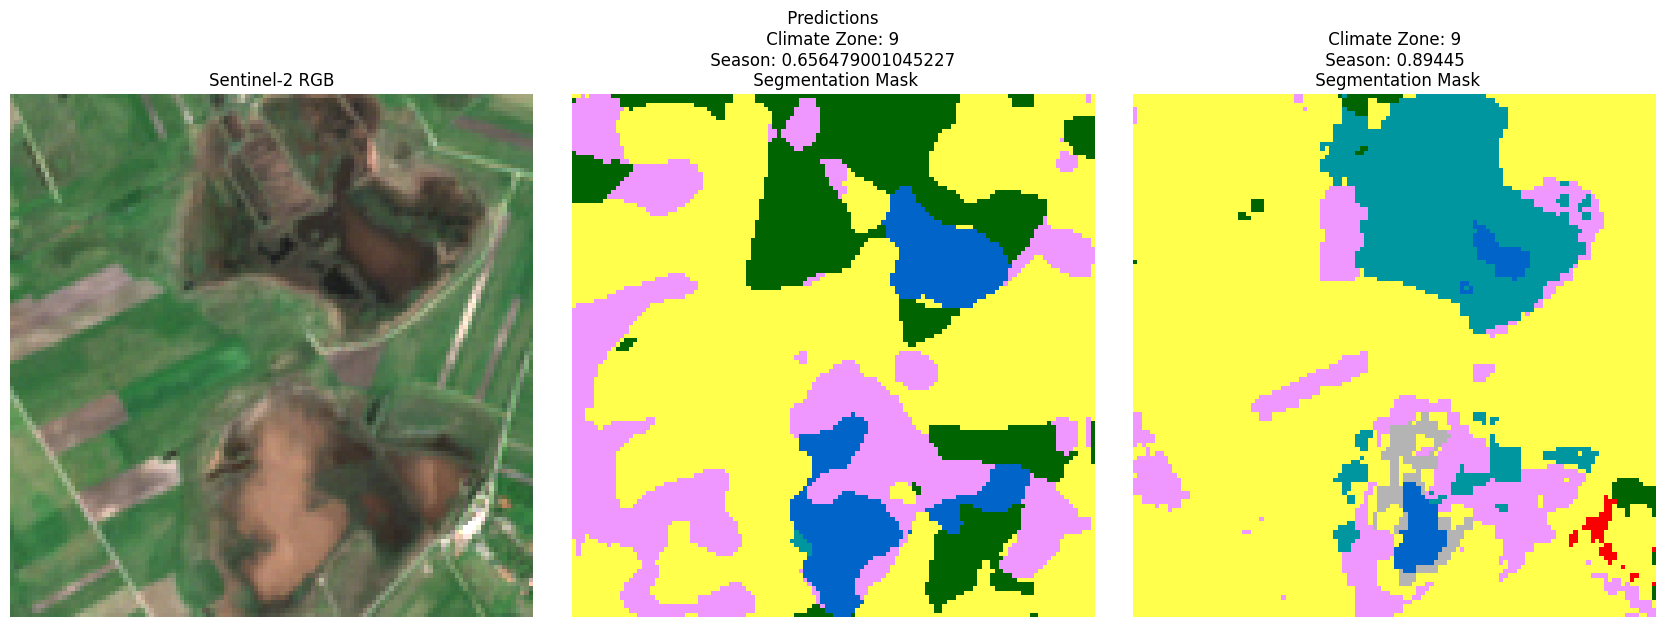

In [73]:
data_module.valset.dataset.dataset.visualise_predictions(test_idx, [output_reg.item(), torch.argmax(output_cls).item(), torch.argmax(output_seg.squeeze(), 0).cpu()])

<a id='potential-experiments-exercise'></a>
## 8. Potential Experiments - Exercise

As an exercise, there are many experiments you can try to implement. Among those, we propose:

* Instead of using a single-modality as input (Sentinel-2), try some multimodal fusion (for example Sentinel 1 and Sentinel 2) as was shown in the previous "Data Fusion" tutorial.

* Tune loss weights, and see how they affect the performances, both quantitatively and qualitatively.

* Compare dual vs multi-tasks.

<a id='references'></a>
## 10. References

[UNet Model](https://github.com/milesial/Pytorch-UNet)